In [1]:
import numpy as np
import pandas as pd
import torch
import os
import time 
import copy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set(font_scale=1)

import importlib
import random 
from skbio import TreeNode
from SimulationResult import SimulationResult
from scipy.spatial.distance import pdist, squareform

/Users/sitarapersad/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
## How many cells does the real data end up with?
## Did this seed from one cell? 

import pickle
with open('d21_indel_distributions.p', 'rb') as f:
    indel_distributions = pickle.load(f)

slow_guides = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'TATTGCCTCTTAATCGTCTT']
medium_guides = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TTAAGTTTGAGCTCGCGCAA']
fast_guides = ['TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']
plot_distributions = False
for li in [slow_guides, medium_guides, fast_guides]:
    for guide in li:
        dist = indel_distributions[guide]
        try:
            del dist['']
        except KeyError:
            pass
        
        if plot_distributions:
            distvals = np.array(sorted(list(dist.values()), reverse=True))
            distvals = distvals/distvals.sum()
            plt.figure()
            sns.barplot(np.arange(len(distvals)), distvals, linewidth=0)
            plt.title('Density over different edits for guide {0}'.format(guide))
            plt.show()
            plt.close()

# Estimate the mutation probability

# For a given site E_i[%] = E_{i-1}[%] + p(1-E_{i-1}[%])
# E_i = 1-q^i, where q = 1-p 
# Sanity check: 
# E_0 = 1-(1-p)^0 = 0 
# E_1 = 1-(1-p) = p 

# We can choose to use a combination of varying speed guides 

# 4, 7, 14, 21 days -> 4 generations, 7 generations etc (24 hrs for cell cycle?)

# How many generations does 1 day correspond to?
# Slow guides:
slow = [0.09, 0.15, 0.29, 0.4]

# Medium guides
medium = [0.15, 0.35, 0.6, 0.75]

# Fast guides
fast = [0.75, 0.9, 0.95, 0.96]





Slow
0.02330188829047808
0.02294954933760507
0.02416678505263603
0.024031560532588148
Avg
0.02361244580332683

Medium
0.03981541059581217
0.05968505934696777
0.06335350204906998
0.0638822575463951
Avg
0.056684057384561254

Fast
0.2928932188134524
0.28031432699884795
0.19263617565013524
0.14211035031316765
Avg
0.22698851794390082


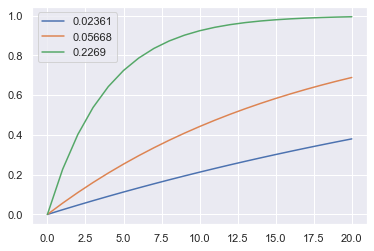

In [3]:
gens = [4,7,14,21]
print('\nSlow')
p_avg = 0
for i, x in enumerate(slow):
    G = 1/gens[i]
    p = 1 - (1-x)**G
    p_avg += p
    print(p)
print("Avg")
print(p_avg/4)

print('\nMedium')
p_avg = 0
for i, x in enumerate(medium):
    G = 1/gens[i]
    p = 1 - (1-x)**G
    p_avg += p
    print(p)
print("Avg")
print(p_avg/4)

print('\nFast')
p_avg = 0
for i, x in enumerate(fast):
    G = 1/gens[i]
    p = 1 - (1-x)**G
    p_avg += p
    print(p)
print("Avg")
print(p_avg/4)    

""" 
Questions
1. tree or forest
2. are the rates based on isolating a clone or from a forest
3. yosef lab was a single tree?? no

try this instead: 
start with many roots (a forest)

reproduction rate varying / same ?vfr 

"""

plt.figure()
for p in [0.02361, 0.05668, 0.2269]:
    q = 1-p
    plt.plot(np.arange(21), 1-q**np.arange(21), label=p)
plt.legend()
plt.show()
plt.close()

rate = {}
rate['slow'] = 0.02361
rate['medium'] = 0.05668
rate['fast'] = 0.2269

## Perform a lineage tracing experiment 

In [5]:
slow_guides = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'TATTGCCTCTTAATCGTCTT']
medium_guides = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TTAAGTTTGAGCTCGCGCAA']
fast_guides = ['TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']

ssm = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT','AATCCCTAGTAGATTAGCCT']
smm = ['AGCTGCTTAGGGCGCAGCCT', 'AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA']
ssf = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'CCTCCCGTAGTGTTGAGTCA']
smf = ['AGCTGCTTAGGGCGCAGCCT', 'AATCCCTAGTAGATTAGCCT', 'CCTCCCGTAGTGTTGAGTCA']
sff = ['AGCTGCTTAGGGCGCAGCCT', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']
mmf = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TAATTCCGGACGAAATCTTG']
mff = ['AATCCCTAGTAGATTAGCCT', 'TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT']


results = {'Guides':[], 'Num_Distinct_Edits':[], 
           'Min_depths':[], 'Num_Mutations':[],
           'Recurring_Characters':[],  
           'Recurring_Characters_%':[],
           'Recurring_Mutations' : [],
           'Recurring_Mutations_%': []
          }

subsampled_results = {'Guides':[], 'Total_Mutations':[], 'Distinct_Mutations':[], 'Recurring_Mutations':[], 'Recurring_Mutations_%':[], 'Unique_Cells': [] }

timers = {}

lists_of_guides = [slow_guides, ssm, smm, ssf, smf, sff, medium_guides, mmf, mff, fast_guides]
labels = ['sss','ssm','smm','ssf','smf','sff', 'mmm', 'mmf','mff', 'fff']
verbose = False
tree_depth = 20
num_runs = 3
n_subsample = 1000
num_arrays = 10

init_cell_list = [1, 5, 10, 50, 100]
death_rep_probs = [(0.1, 0.75), (0.2, 0.75), (0.1,0.9)]
cancer_probs = [1e-3, 1e-2]
missing_fracs = [0.2, 0.1, 0.05, 0.01, 0]

debug = False
compute_tree = False

if debug:
    lists_of_guides = [smf]
    labels = ['smf']
    tree_depth = 20
    num_runs = 3
    n_subsample = 500
    num_arrays = 10
    init_cell_list = [1]
    
    death_rep_probs = [(0.1, 0.75)]
    cancer_probs = cancer_probs = [1e-3, 1e-2,1e-1]
    
    missing_fracs = [0]

Label: sss
List of targets:  [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (5, 0), (5, 1), (5, 2), (6, 0), (6, 1), (6, 2), (7, 0), (7, 1), (7, 2), (8, 0), (8, 1), (8, 2), (9, 0), (9, 1), (9, 2)]
Generation: 0
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19
drop 6000 (1000, 30)


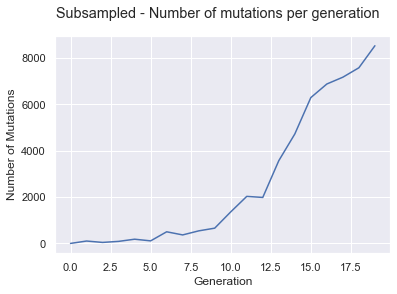

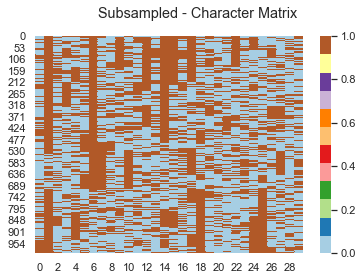

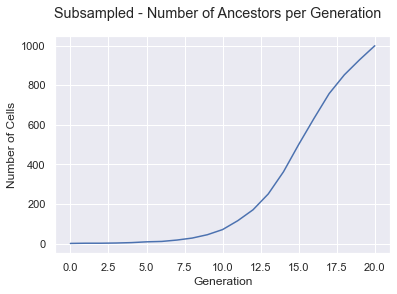

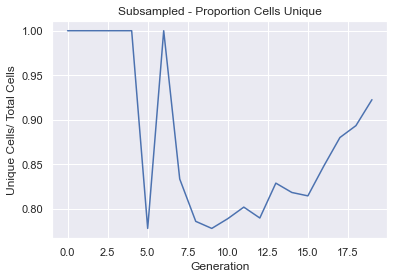

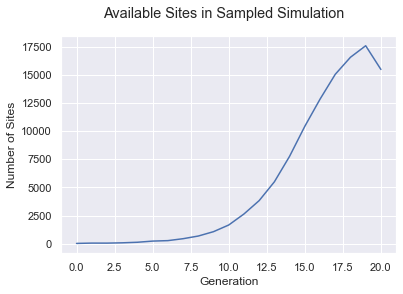

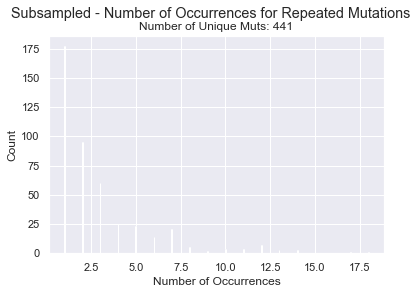

Reconstructing greedy tree
Getting tree with missing data.
Got true_tree
Computing score before reassignment.
Score before reassignment:  0.657
Reassigned 736 cells out of a total of 1000 cells.
Removed 22 leaves after reassigning cells.
Score after reassignment:  0.664
Starting NJ with 44 nodes
Starting NJ with 41 nodes


/Users/sitarapersad/lineageTracing/modified_nj.py:52: RuntimeWarning: invalid value encountered in subtract
  Q = D*(fm.shape[0]-2) - R


Starting NJ with 19 nodes
Starting NJ with 21 nodes
Starting NJ with 32 nodes
Starting NJ with 31 nodes
Starting NJ with 30 nodes
Starting NJ with 24 nodes
Starting NJ with 35 nodes
Starting NJ with 18 nodes
Starting NJ with 41 nodes
Starting NJ with 48 nodes
Starting NJ with 9 nodes
Starting NJ with 43 nodes
Starting NJ with 37 nodes
Starting NJ with 23 nodes
Starting NJ with 34 nodes
Starting NJ with 40 nodes
Starting NJ with 46 nodes
Starting NJ with 37 nodes
Starting NJ with 34 nodes
Starting NJ with 41 nodes
Starting NJ with 35 nodes
Starting NJ with 44 nodes
Starting NJ with 29 nodes
Starting NJ with 38 nodes
Starting NJ with 14 nodes
Starting NJ with 45 nodes
Starting NJ with 37 nodes
Starting NJ with 30 nodes
Score after neighbor joining:  0.647


/Users/sitarapersad/.local/lib/python3.7/site-packages/cassiopeia/TreeSolver/lineage_solver/ILP_solver.py:11: UserWarning: No module called gurobipy found. ILP solver will exit automatically if used.
  warnings.warn("No module called gurobipy found. ILP solver will exit automatically if used.")


Reconstructing Cassiopeia Tree
Getting tree with missing data.
Failed to find 3 triplets out of 1000 due to nodes missing from reconstructed tree.
Cassiopeia: 0.954864593781344
Generation: 0
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19
drop 6000 (1000, 30)


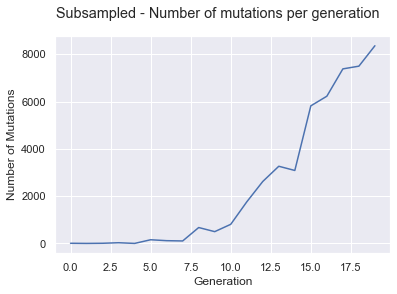

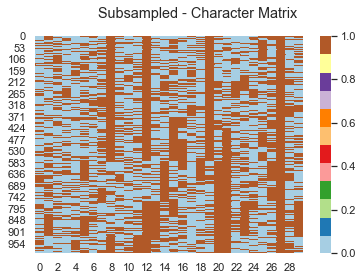

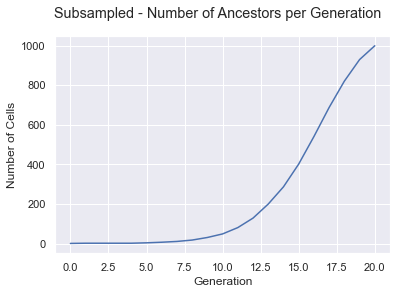

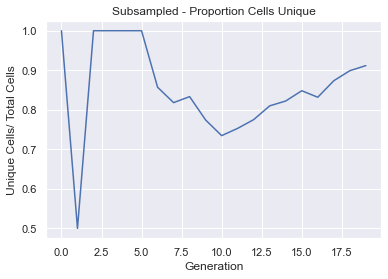

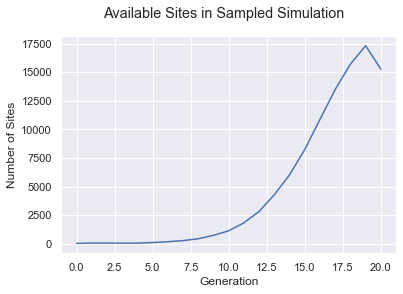

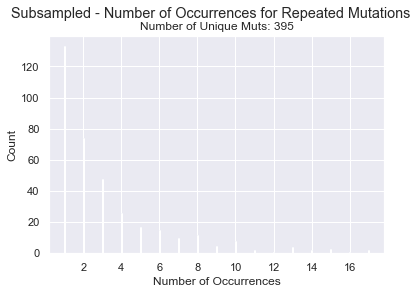

Reconstructing greedy tree
Getting tree with missing data.
Got true_tree
Computing score before reassignment.
Score before reassignment:  0.516
Reassigned 684 cells out of a total of 1000 cells.
Removed 23 leaves after reassigning cells.
Score after reassignment:  0.53
Starting NJ with 44 nodes
Starting NJ with 24 nodes


/Users/sitarapersad/lineageTracing/modified_nj.py:52: RuntimeWarning: invalid value encountered in subtract
  Q = D*(fm.shape[0]-2) - R


Starting NJ with 38 nodes
Starting NJ with 27 nodes
Starting NJ with 23 nodes
Starting NJ with 15 nodes
Starting NJ with 13 nodes
Starting NJ with 9 nodes
Starting NJ with 9 nodes
Starting NJ with 7 nodes
Starting NJ with 7 nodes
Starting NJ with 5 nodes
Starting NJ with 47 nodes
Starting NJ with 16 nodes
Starting NJ with 44 nodes
Starting NJ with 48 nodes
Starting NJ with 20 nodes
Starting NJ with 45 nodes
Starting NJ with 15 nodes
Starting NJ with 45 nodes
Starting NJ with 44 nodes
Starting NJ with 39 nodes
Starting NJ with 40 nodes
Starting NJ with 23 nodes
Starting NJ with 33 nodes
Starting NJ with 19 nodes
Starting NJ with 32 nodes
Starting NJ with 14 nodes
Starting NJ with 45 nodes
Starting NJ with 21 nodes
Starting NJ with 19 nodes
Starting NJ with 40 nodes
Starting NJ with 20 nodes
Starting NJ with 21 nodes
Starting NJ with 41 nodes
Starting NJ with 19 nodes
Starting NJ with 29 nodes
Score after neighbor joining:  0.551
Reconstructing Cassiopeia Tree
Getting tree with missing d

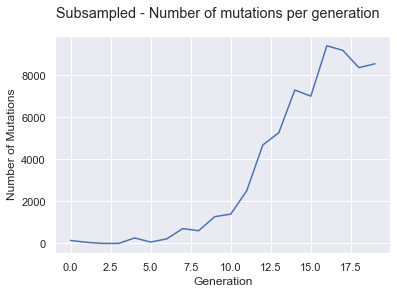

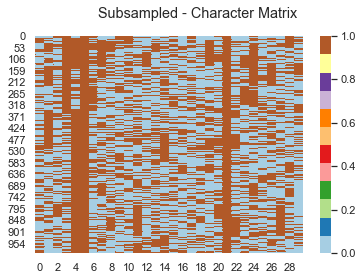

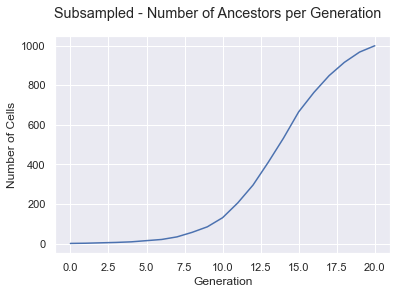

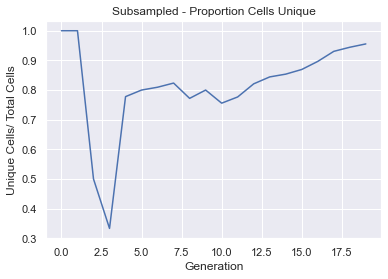

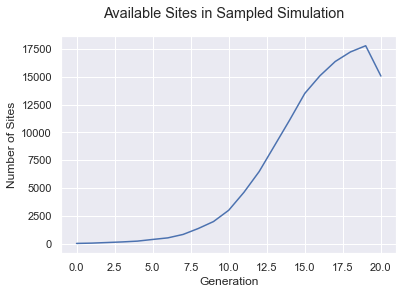

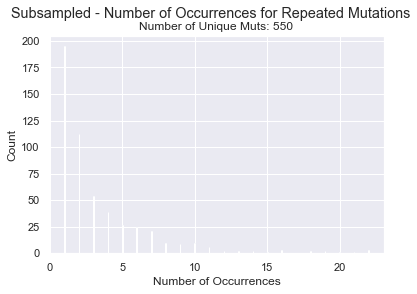

Reconstructing greedy tree
Getting tree with missing data.
Got true_tree
Computing score before reassignment.
Score before reassignment:  0.449
Reassigned 749 cells out of a total of 1000 cells.
Removed 25 leaves after reassigning cells.
Score after reassignment:  0.444
Starting NJ with 26 nodes
Starting NJ with 19 nodes
Starting NJ with 43 nodes


/Users/sitarapersad/lineageTracing/modified_nj.py:52: RuntimeWarning: invalid value encountered in subtract
  Q = D*(fm.shape[0]-2) - R


Starting NJ with 33 nodes
Starting NJ with 23 nodes
Starting NJ with 16 nodes
Starting NJ with 31 nodes
Starting NJ with 28 nodes
Starting NJ with 26 nodes
Starting NJ with 18 nodes
Starting NJ with 16 nodes
Starting NJ with 14 nodes
Starting NJ with 12 nodes
Starting NJ with 49 nodes
Starting NJ with 46 nodes
Starting NJ with 41 nodes
Starting NJ with 33 nodes
Starting NJ with 15 nodes
Starting NJ with 43 nodes
Starting NJ with 19 nodes
Starting NJ with 16 nodes
Starting NJ with 11 nodes
Starting NJ with 10 nodes
Starting NJ with 7 nodes
Starting NJ with 7 nodes
Starting NJ with 6 nodes
Starting NJ with 50 nodes
Starting NJ with 23 nodes
Starting NJ with 12 nodes
Starting NJ with 10 nodes
Starting NJ with 41 nodes
Starting NJ with 49 nodes
Starting NJ with 24 nodes
Starting NJ with 20 nodes
Starting NJ with 19 nodes
Starting NJ with 44 nodes
Starting NJ with 36 nodes
Starting NJ with 31 nodes
Starting NJ with 33 nodes
Score after neighbor joining:  0.454
Reconstructing Cassiopeia Tree

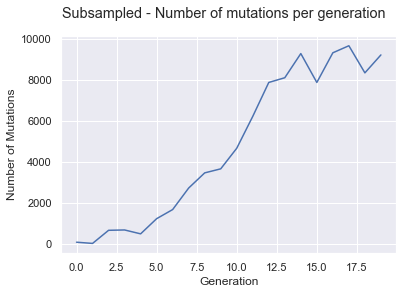

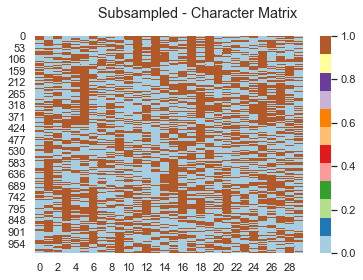

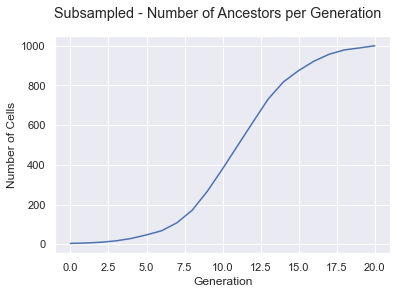

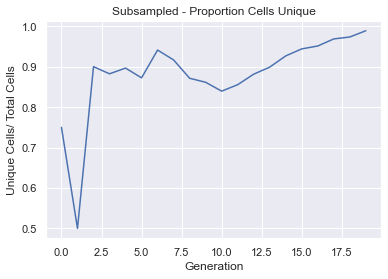

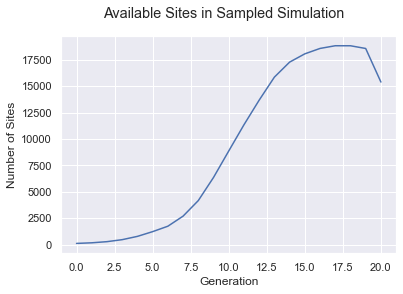

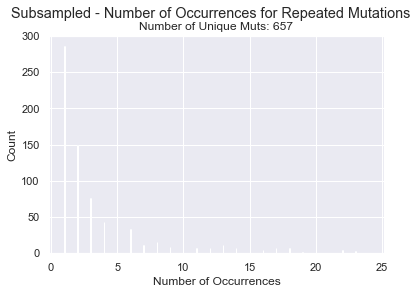

Reconstructing greedy tree
Getting tree with missing data.
Got true_tree
Computing score before reassignment.
Score before reassignment:  0.521
Reassigned 581 cells out of a total of 1000 cells.
Removed 20 leaves after reassigning cells.
Score after reassignment:  0.487
Starting NJ with 25 nodes
Starting NJ with 37 nodes
Starting NJ with 28 nodes


/Users/sitarapersad/lineageTracing/modified_nj.py:52: RuntimeWarning: invalid value encountered in subtract
  Q = D*(fm.shape[0]-2) - R


Starting NJ with 28 nodes
Starting NJ with 47 nodes
Starting NJ with 13 nodes
Starting NJ with 9 nodes
Starting NJ with 8 nodes
Starting NJ with 44 nodes
Starting NJ with 45 nodes
Starting NJ with 21 nodes
Starting NJ with 35 nodes
Starting NJ with 21 nodes
Starting NJ with 47 nodes
Starting NJ with 16 nodes
Starting NJ with 30 nodes
Starting NJ with 22 nodes
Starting NJ with 41 nodes
Starting NJ with 15 nodes
Starting NJ with 24 nodes
Starting NJ with 29 nodes
Starting NJ with 30 nodes
Starting NJ with 47 nodes
Starting NJ with 50 nodes
Starting NJ with 47 nodes
Starting NJ with 43 nodes
Starting NJ with 26 nodes
Starting NJ with 21 nodes
Starting NJ with 18 nodes
Starting NJ with 18 nodes
Starting NJ with 14 nodes
Starting NJ with 12 nodes
Starting NJ with 10 nodes
Starting NJ with 10 nodes
Starting NJ with 9 nodes
Starting NJ with 8 nodes
Starting NJ with 6 nodes
Starting NJ with 46 nodes
Score after neighbor joining:  0.513
Reconstructing Cassiopeia Tree
Getting tree with missing d

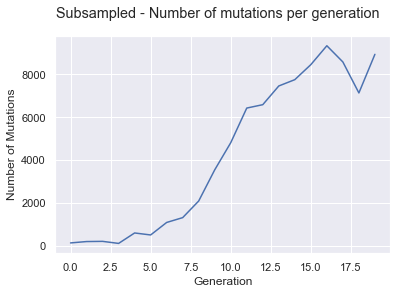

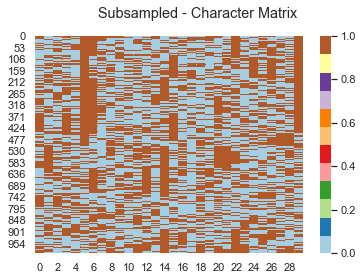

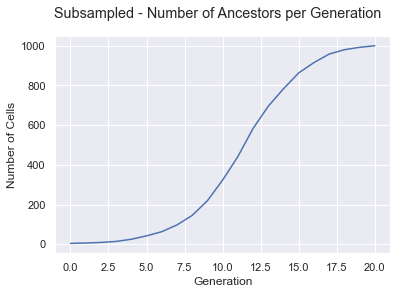

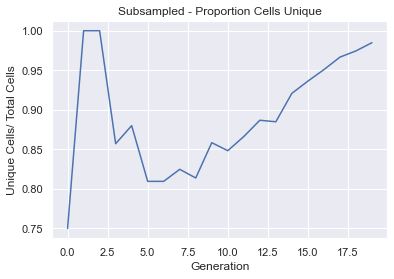

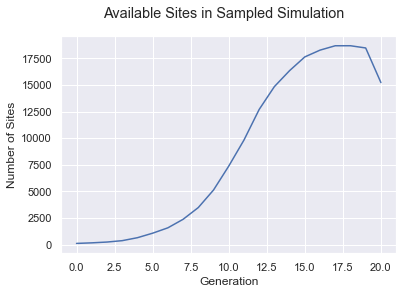

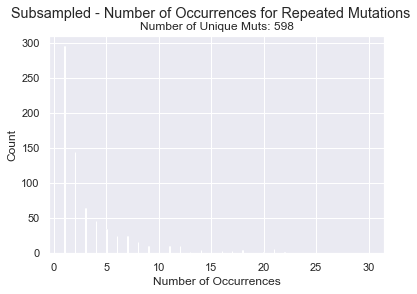

Reconstructing greedy tree
Getting tree with missing data.
Got true_tree
Computing score before reassignment.
Score before reassignment:  0.616
Reassigned 585 cells out of a total of 1000 cells.
Removed 20 leaves after reassigning cells.
Score after reassignment:  0.641
Starting NJ with 43 nodes
Starting NJ with 43 nodes


/Users/sitarapersad/lineageTracing/modified_nj.py:52: RuntimeWarning: invalid value encountered in subtract
  Q = D*(fm.shape[0]-2) - R


Starting NJ with 33 nodes
Starting NJ with 28 nodes
Starting NJ with 39 nodes
Starting NJ with 18 nodes
Starting NJ with 46 nodes
Starting NJ with 10 nodes
Starting NJ with 42 nodes
Starting NJ with 36 nodes
Starting NJ with 39 nodes
Starting NJ with 45 nodes
Starting NJ with 13 nodes
Starting NJ with 13 nodes
Starting NJ with 33 nodes
Starting NJ with 50 nodes
Starting NJ with 19 nodes
Starting NJ with 26 nodes
Starting NJ with 28 nodes
Starting NJ with 40 nodes
Starting NJ with 17 nodes
Starting NJ with 24 nodes
Starting NJ with 40 nodes
Starting NJ with 43 nodes
Starting NJ with 14 nodes
Starting NJ with 33 nodes
Starting NJ with 29 nodes
Starting NJ with 22 nodes
Starting NJ with 19 nodes
Starting NJ with 16 nodes
Starting NJ with 15 nodes
Starting NJ with 14 nodes
Starting NJ with 12 nodes
Starting NJ with 10 nodes
Starting NJ with 48 nodes
Score after neighbor joining:  0.658
Reconstructing Cassiopeia Tree
Getting tree with missing data.
Failed to find 2 triplets out of 1000 due 

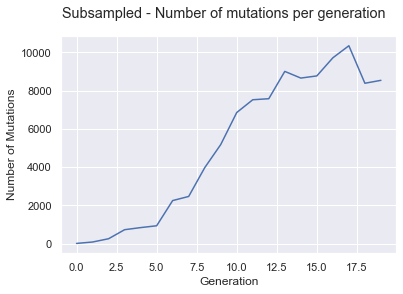

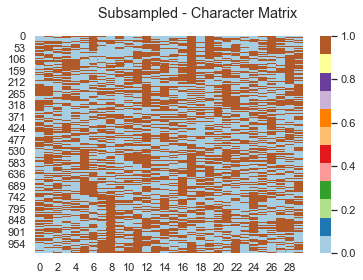

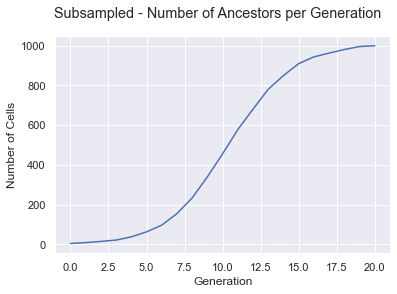

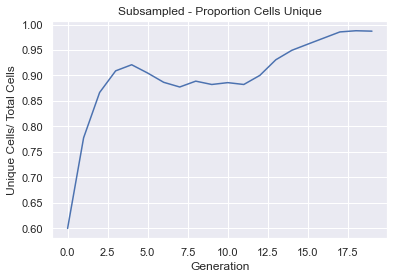

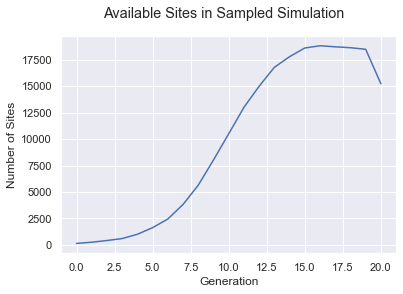

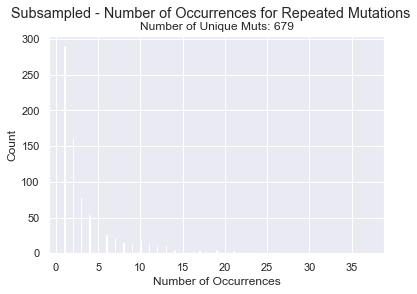

Reconstructing greedy tree
Getting tree with missing data.
Got true_tree
Computing score before reassignment.
Score before reassignment:  0.521
Reassigned 498 cells out of a total of 1000 cells.
Removed 14 leaves after reassigning cells.
Score after reassignment:  0.524
Starting NJ with 49 nodes


/Users/sitarapersad/lineageTracing/modified_nj.py:52: RuntimeWarning: invalid value encountered in subtract
  Q = D*(fm.shape[0]-2) - R


Starting NJ with 47 nodes
Starting NJ with 39 nodes
Starting NJ with 29 nodes
Starting NJ with 22 nodes
Starting NJ with 14 nodes
Starting NJ with 46 nodes
Starting NJ with 46 nodes
Starting NJ with 29 nodes
Starting NJ with 41 nodes
Starting NJ with 25 nodes
Starting NJ with 30 nodes
Starting NJ with 31 nodes
Starting NJ with 21 nodes
Starting NJ with 21 nodes
Starting NJ with 24 nodes
Starting NJ with 37 nodes
Starting NJ with 43 nodes
Starting NJ with 47 nodes
Starting NJ with 27 nodes
Starting NJ with 36 nodes
Starting NJ with 30 nodes
Starting NJ with 28 nodes
Starting NJ with 25 nodes
Starting NJ with 22 nodes
Starting NJ with 18 nodes
Starting NJ with 16 nodes
Starting NJ with 15 nodes
Starting NJ with 15 nodes
Starting NJ with 14 nodes
Starting NJ with 12 nodes
Starting NJ with 12 nodes
Starting NJ with 10 nodes
Starting NJ with 9 nodes
Starting NJ with 7 nodes
Starting NJ with 7 nodes
Starting NJ with 6 nodes
Starting NJ with 50 nodes
Score after neighbor joining:  0.501
Recon

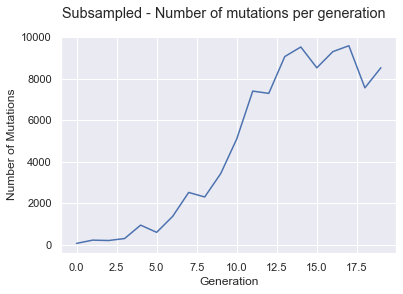

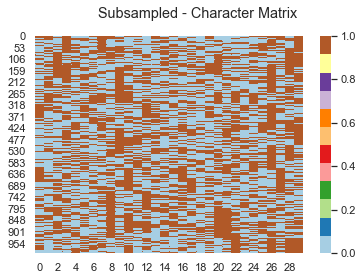

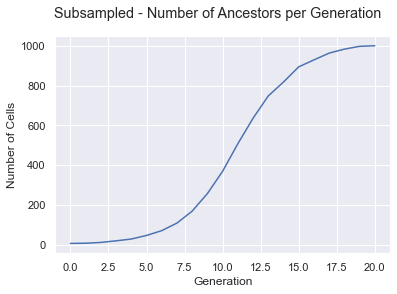

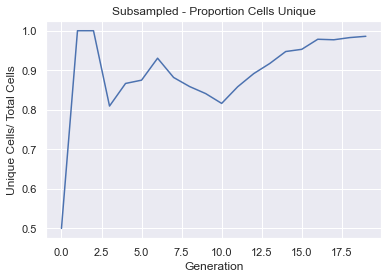

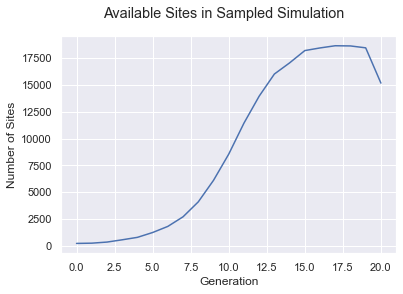

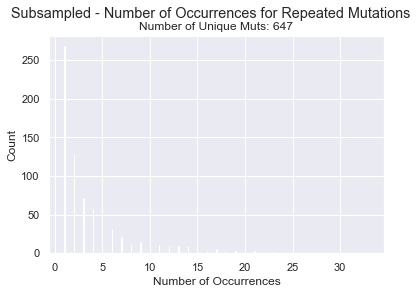

Reconstructing greedy tree
Getting tree with missing data.
Got true_tree
Computing score before reassignment.
Score before reassignment:  0.494
Reassigned 631 cells out of a total of 1000 cells.
Removed 22 leaves after reassigning cells.
Score after reassignment:  0.478
Starting NJ with 41 nodes
Starting NJ with 39 nodes


/Users/sitarapersad/lineageTracing/modified_nj.py:52: RuntimeWarning: invalid value encountered in subtract
  Q = D*(fm.shape[0]-2) - R


Starting NJ with 16 nodes
Starting NJ with 45 nodes
Starting NJ with 39 nodes
Starting NJ with 48 nodes
Starting NJ with 25 nodes
Starting NJ with 34 nodes
Starting NJ with 34 nodes
Starting NJ with 25 nodes
Starting NJ with 47 nodes
Starting NJ with 43 nodes
Starting NJ with 32 nodes
Starting NJ with 22 nodes
Starting NJ with 45 nodes
Starting NJ with 43 nodes
Starting NJ with 28 nodes
Starting NJ with 35 nodes
Starting NJ with 19 nodes
Starting NJ with 29 nodes
Starting NJ with 45 nodes
Starting NJ with 46 nodes
Starting NJ with 11 nodes
Starting NJ with 45 nodes
Starting NJ with 9 nodes
Starting NJ with 17 nodes
Starting NJ with 15 nodes
Starting NJ with 14 nodes
Starting NJ with 13 nodes
Starting NJ with 13 nodes
Starting NJ with 12 nodes
Starting NJ with 10 nodes
Starting NJ with 10 nodes
Starting NJ with 8 nodes
Starting NJ with 43 nodes
Score after neighbor joining:  0.487
Reconstructing Cassiopeia Tree
Getting tree with missing data.
Cassiopeia: 0.826
Generation: 0
Generation: 

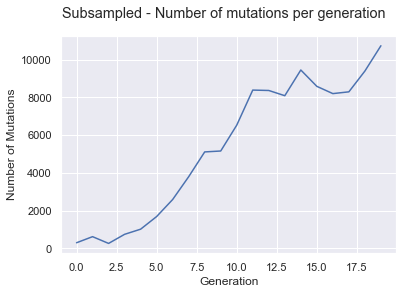

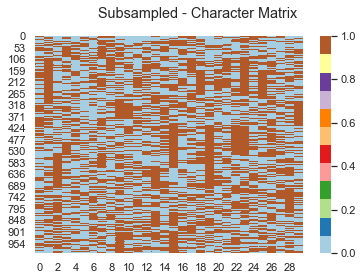

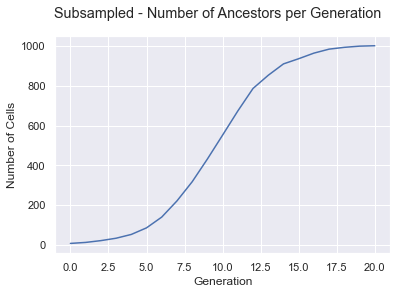

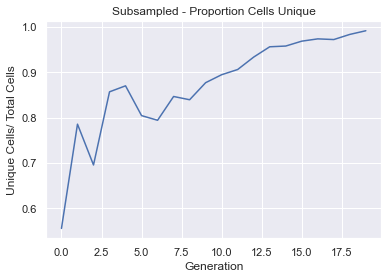

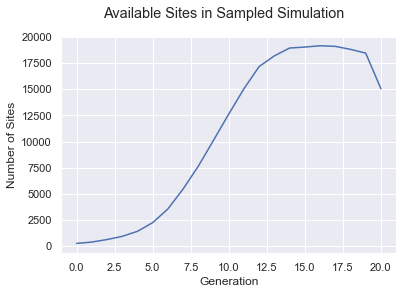

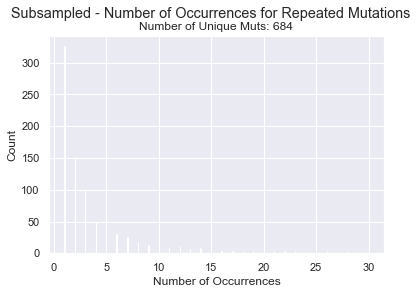

Reconstructing greedy tree
Getting tree with missing data.
Got true_tree
Computing score before reassignment.
Score before reassignment:  0.448
Reassigned 727 cells out of a total of 1000 cells.
Removed 22 leaves after reassigning cells.
Score after reassignment:  0.439
Starting NJ with 17 nodes
Starting NJ with 42 nodes


/Users/sitarapersad/lineageTracing/modified_nj.py:52: RuntimeWarning: invalid value encountered in subtract
  Q = D*(fm.shape[0]-2) - R


Starting NJ with 47 nodes
Starting NJ with 44 nodes
Starting NJ with 26 nodes
Starting NJ with 30 nodes
Starting NJ with 9 nodes
Starting NJ with 47 nodes
Starting NJ with 35 nodes
Starting NJ with 20 nodes
Starting NJ with 38 nodes
Starting NJ with 16 nodes
Starting NJ with 17 nodes
Starting NJ with 32 nodes
Starting NJ with 15 nodes
Starting NJ with 46 nodes
Starting NJ with 38 nodes
Starting NJ with 27 nodes
Starting NJ with 21 nodes
Starting NJ with 37 nodes
Starting NJ with 44 nodes
Starting NJ with 39 nodes
Starting NJ with 39 nodes
Starting NJ with 35 nodes
Starting NJ with 33 nodes
Starting NJ with 22 nodes
Starting NJ with 22 nodes
Starting NJ with 21 nodes
Starting NJ with 21 nodes
Starting NJ with 17 nodes
Starting NJ with 14 nodes
Starting NJ with 11 nodes
Starting NJ with 10 nodes
Starting NJ with 7 nodes
Starting NJ with 6 nodes
Starting NJ with 6 nodes
Starting NJ with 49 nodes
Score after neighbor joining:  0.46
Reconstructing Cassiopeia Tree
Getting tree with missing d

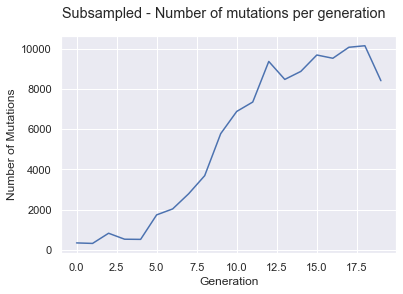

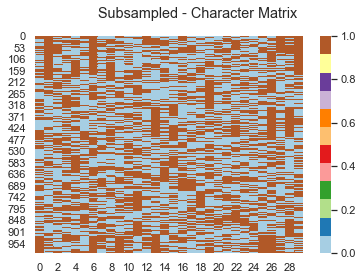

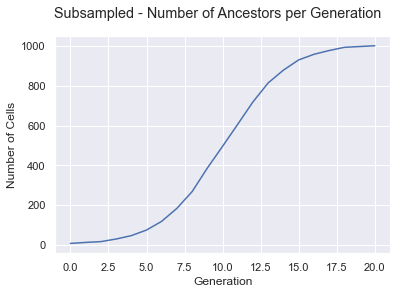

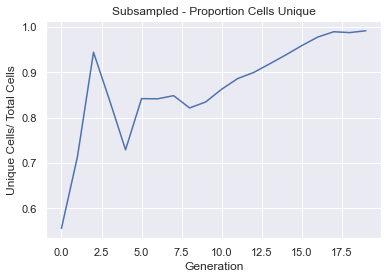

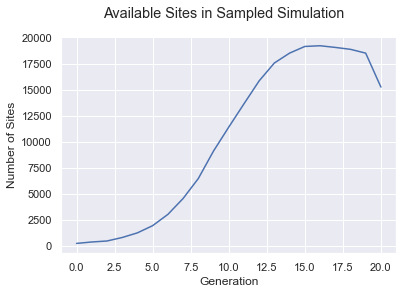

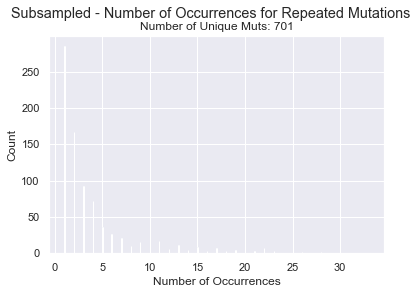

Reconstructing greedy tree
Getting tree with missing data.
Got true_tree
Computing score before reassignment.
Score before reassignment:  0.45
Reassigned 538 cells out of a total of 1000 cells.
Removed 15 leaves after reassigning cells.
Score after reassignment:  0.455
Starting NJ with 37 nodes
Starting NJ with 26 nodes


/Users/sitarapersad/lineageTracing/modified_nj.py:52: RuntimeWarning: invalid value encountered in subtract
  Q = D*(fm.shape[0]-2) - R


Starting NJ with 42 nodes
Starting NJ with 21 nodes
Starting NJ with 38 nodes
Starting NJ with 46 nodes
Starting NJ with 9 nodes
Starting NJ with 25 nodes
Starting NJ with 12 nodes
Starting NJ with 50 nodes
Starting NJ with 27 nodes
Starting NJ with 37 nodes
Starting NJ with 22 nodes
Starting NJ with 30 nodes
Starting NJ with 35 nodes
Starting NJ with 34 nodes
Starting NJ with 35 nodes
Starting NJ with 27 nodes
Starting NJ with 42 nodes
Starting NJ with 45 nodes
Starting NJ with 13 nodes
Starting NJ with 49 nodes
Starting NJ with 44 nodes
Starting NJ with 41 nodes
Starting NJ with 38 nodes
Starting NJ with 24 nodes
Starting NJ with 20 nodes
Starting NJ with 19 nodes
Starting NJ with 15 nodes
Starting NJ with 11 nodes
Starting NJ with 9 nodes
Starting NJ with 8 nodes
Starting NJ with 7 nodes
Starting NJ with 7 nodes
Starting NJ with 6 nodes
Starting NJ with 49 nodes
Score after neighbor joining:  0.47
Reconstructing Cassiopeia Tree
Getting tree with missing data.
Cassiopeia: 0.764
Gener

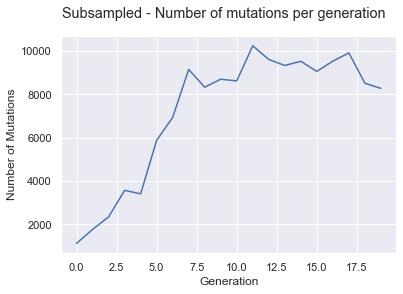

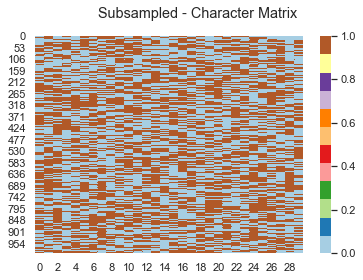

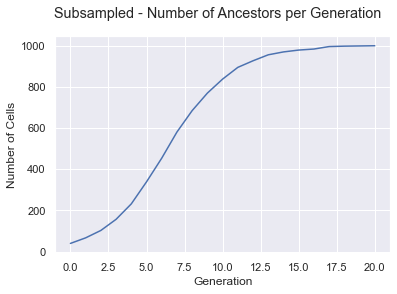

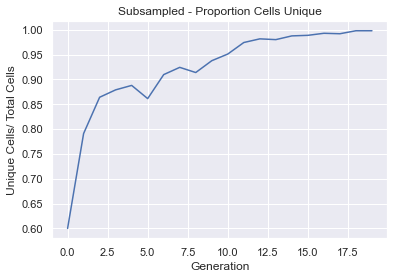

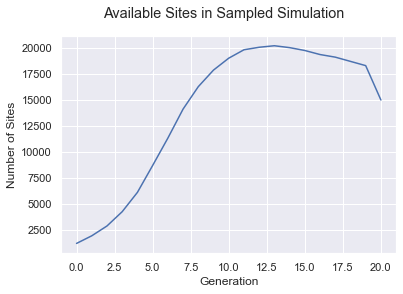

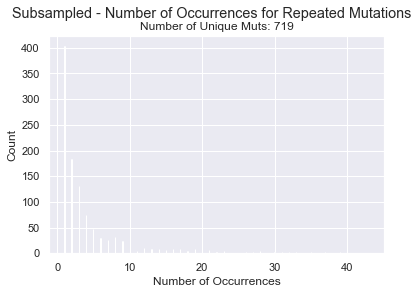

Reconstructing greedy tree
Getting tree with missing data.
Got true_tree
Computing score before reassignment.
Score before reassignment:  0.345
Reassigned 390 cells out of a total of 1000 cells.
Removed 7 leaves after reassigning cells.
Score after reassignment:  0.342
Starting NJ with 32 nodes
Starting NJ with 11 nodes


/Users/sitarapersad/lineageTracing/modified_nj.py:52: RuntimeWarning: invalid value encountered in subtract
  Q = D*(fm.shape[0]-2) - R


Starting NJ with 40 nodes
Starting NJ with 25 nodes
Starting NJ with 17 nodes
Starting NJ with 35 nodes
Starting NJ with 33 nodes
Starting NJ with 31 nodes
Starting NJ with 12 nodes
Starting NJ with 48 nodes
Starting NJ with 47 nodes
Starting NJ with 43 nodes
Starting NJ with 40 nodes
Starting NJ with 37 nodes
Starting NJ with 33 nodes
Starting NJ with 30 nodes
Starting NJ with 29 nodes
Starting NJ with 28 nodes
Starting NJ with 26 nodes
Starting NJ with 24 nodes
Starting NJ with 22 nodes
Starting NJ with 21 nodes
Starting NJ with 19 nodes
Starting NJ with 18 nodes
Starting NJ with 16 nodes
Starting NJ with 15 nodes
Starting NJ with 15 nodes
Starting NJ with 14 nodes
Starting NJ with 13 nodes
Starting NJ with 13 nodes
Starting NJ with 12 nodes
Starting NJ with 12 nodes
Starting NJ with 11 nodes
Starting NJ with 11 nodes
Starting NJ with 10 nodes
Starting NJ with 9 nodes
Starting NJ with 9 nodes
Starting NJ with 8 nodes
Starting NJ with 8 nodes
Starting NJ with 8 nodes
Starting NJ with 

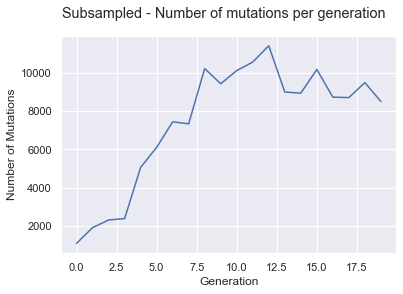

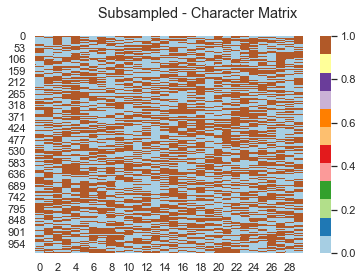

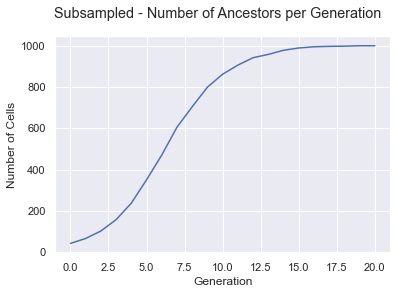

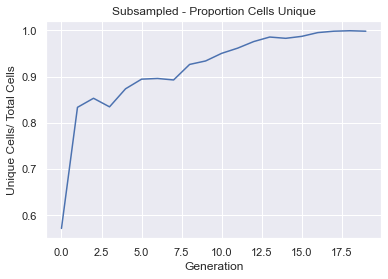

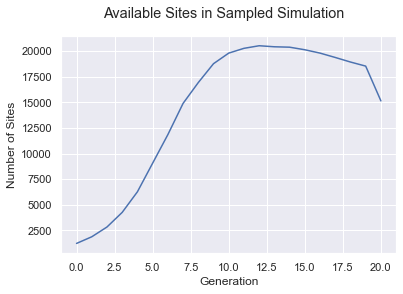

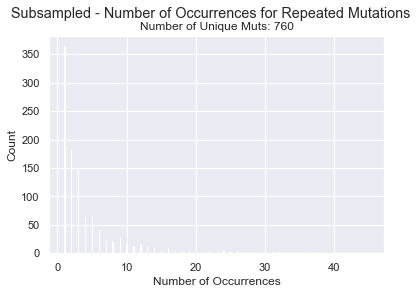

Reconstructing greedy tree
Getting tree with missing data.


In [ ]:
import crispr_lib
importlib.reload(crispr_lib)

simulation_list = []


missing_results = {'params':[('death_prob', 'rep_prob','cancer_prob','guide','init_cells','run','missing_frac')], 
           'outcomes':[('greedy_tree', 'scores', 'greedy_tree_prob','scores_prob','cass_tree', 'cass_scores', 'simulation')]}

for missing_frac in missing_fracs:
    for init_death_prob, init_repr_prob in death_rep_probs:
        for cancer_prob in cancer_probs:
            for i, list_of_guides in enumerate(lists_of_guides):
                label = labels[i]
                print('Label:', label)

                # Each array has 3-6 targets, we insert ~10 arrays. This gives us 30-60 sites
                site_ix = 0
                target_distributions = {}
                speed = {}
                for guide in list_of_guides:
                    dist = indel_distributions[guide]
                    try:
                        del dist['']
                    except KeyError:
                        pass
                    distvals = np.array(sorted(list(dist.values()), reverse=True))
                    distvals = distvals/distvals.sum()
                    target_distributions[site_ix] = distvals
                    if guide in slow_guides:
                        speed[site_ix] = 'slow'
                    elif guide in medium_guides:
                        speed[site_ix] = 'medium'
                    else:
                        speed[site_ix] = 'fast'

                    site_ix += 1

                num_targets = site_ix 
                num_edit_sites = num_targets * num_arrays

                import itertools
                targets = list(itertools.product(np.arange(num_arrays), np.arange(num_targets)))
                print('List of targets: ', targets)

                deletions = []
                mutation_probs = []
                for array, target in targets:
                    deletions.append(target_distributions[target])
                    mutation_probs.append(rate[speed[target]])

                deletions_probs = pd.DataFrame(deletions)
                deletions_probs = torch.DoubleTensor(deletions_probs.fillna(0.0).values)

                # Each edit site has a different mutation probability 
                mutation_probs= np.array(mutation_probs)

                deletions_probs = deletions_probs[:, :100]
                deletions_probs /= deletions_probs.sum(1, keepdims=True)

                edit_probs = np.hstack([mutation_probs.reshape(-1,1), (1-mutation_probs.reshape(-1,1))*deletions_probs.numpy()])



                for init_cells in init_cell_list:

                    for run in range(num_runs):

                        try:
                            try:
                                simulation = crispr_lib.lineageSimulationImbalanced(label, tree_depth, 
                                                                         num_edit_sites, deletions_probs, 
                                                                         mutation_probs, edit_probs, 
                                                                         init_cells=init_cells, 
                                                                         n_subsample=n_subsample,
                                                                         missing_fraction= missing_frac,
                                                                         identify_recurrent_muts=False)
                            except:
                                # If simulation fails, try again to generate sufficient cells
                                simulation = crispr_lib.lineageSimulationImbalanced(label, tree_depth, 
                                                                         num_edit_sites, deletions_probs, 
                                                                         mutation_probs, edit_probs, 
                                                                         init_cells=init_cells, 
                                                                         n_subsample=n_subsample,
                                                                         missing_fraction=missing_frac, 
                                                                         identify_recurrent_muts=False)


                            simulation_list.append(simulation)

                            ## Benchmark reconstruction performance on this simulation (Cassiopeia vs Greedy + NJ)
                            from greedy_reconstruct import greedy_probabilistic
                            # Compute reconstruction accuracy from greedy + reassignment method
                            greedy_tree, scores = greedy_probabilistic(simulation,
                                                                       impute_missing_data=False,
                                                                       max_cells_per_greedy_node = 50,
                                                                       reassign=True,
                                                                      consensus_assignment=False)
                            

                            from cass_helper import cassiopeia_reconstruct

                            from cassiopeia.TreeSolver.Cassiopeia_Tree import Cassiopeia_Tree
                            from cassiopeia.TreeSolver.score_triplets import score_triplets
                            from cassiopeia.TreeSolver.Node import Node 
                            from cassiopeia.TreeSolver.lineage_solver.lineage_solver import solve_lineage_instance

                            # Compute Cassiopeia reconstruction accuracy
                            cass_tree, cass_scores = cassiopeia_reconstruct(simulation)
                            
                            missing_results['params'].append((init_death_prob, init_repr_prob, cancer_prob, label, init_cells, run, missing_frac))
                            missing_results['outcomes'].append((greedy_tree, scores, cass_tree, cass_scores, simulation))
                            
                        except Exception as e:
#                             print(e)
                            raise(e)
                            missing_results['params'].append((init_death_prob, init_repr_prob, cancer_prob, label, init_cells, run, missing_frac))
                            missing_results['outcomes'].append((e, simulation))

## Tree Reconstructions 

Compare various methods of tree reconstruction to determine which has the best performance

In [12]:
missing_results['outcomes'][-1]

(<CellGroupNode, name: hdn-86267, internal node count: 440, tips count: 442>,
 {'before': 0.96, 'after': 0.973, 'nj': 0.967},
 <CellGroupNode, name: hdn-95219, internal node count: 440, tips count: 442>,
 {'before': 0.97, 'after': 0.967, 'nj': 0.974},
 <TreeNode, name: 15973, internal node count: 221, tips count: 368>,
 {'our_score': 0.9756554307116105},
 <SimulationResult.SimulationResult at 0x7fab5e472850>)

In [15]:
# Summarise results of experiment:

params = missing_results['params']
outcomes = missing_results['outcomes']

print(params[0])
print(outcomes[0])

failed_outcomes = {'params':[], 'outcomes':[]}


summary = {'death_prob':[], 'rep_prob':[], 'cancer_prob':[], 'guide':[], 'init_cells':[], 'run':[], 'missing': []
           'before':[], 'after':[], 'nj':[], 'before':[], 'after':[], 'nj':[], 'cassiopeia':[]          } 
for i in range(1, len(params)):
    param = params[i]
    outcome = outcomes[i]
    
    if len(outcome) == 2:
        failed_outcomes['params'].append(param)
        failed_outcomes['outcomes'].append(outcome)
        
        continue
        
    death_prob, rep_prob, cancer_prob, guide, init_cells, run, missing = param
    greedy_tree, scores, greedy_tree_proba, scores_proba, cass_tree, cass_scores, simulation = outcome
    
    summary['death_prob'].append(death_prob)
    summary['rep_prob'].append(rep_prob)
    summary['cancer_prob'].append(cancer_prob)
    summary['guide'].append(guide)
    summary['init_cells'].append(init_cells)
    summary['run'].append(run)
    summary['missing'].append(missing)
    
    summary['before'].append(scores['before'])
    summary['after'].append(scores['after'])
    summary['nj'].append(scores['nj'])
    
    summary['cassiopeia'].append(cass_scores['our_score'])
    

('death_prob', 'rep_prob', 'cancer_prob', 'guide', 'init_cells', 'run', 'missing_frac')
('greedy_tree', 'scores', 'greedy_tree_prob', 'scores_prob', 'cass_tree', 'cass_scores', 'simulation')


In [14]:
param

(0.1, 0.75, 0.001, 'smf', 1, 0, 0)

In [30]:
summary_df = pd.DataFrame(summary)
summary_df['reassign_delta'] = summary_df['after']-summary_df['before']
summary_df['nj_delta'] = summary_df['nj']-summary_df['after']
summary_df['probabilistic_reassign_delta'] = summary_df['probabilistic_after']-summary_df['probabilistic_before']
summary_df['probabilistic_nj_delta'] = summary_df['probabilistic_nj']-summary_df['probabilistic_after']


Text(0.5, 1.0, 'Change in performance for varying reassignment steps')

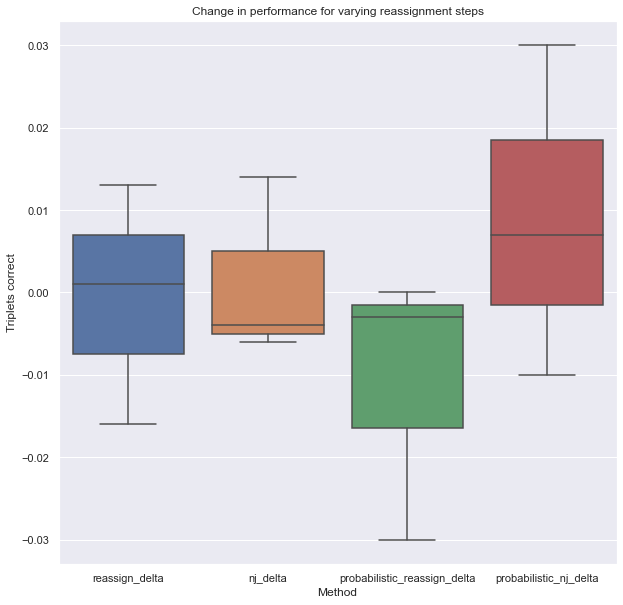

In [33]:


# pd.DataFrame(df)
plt.figure(figsize=(10,10))
xx = pd.melt(summary_df[['reassign_delta', 'nj_delta', 'probabilistic_reassign_delta', 'probabilistic_nj_delta']])
sns.boxplot(x='variable', y='value', data=xx)

plt.ylabel('Triplets correct')
plt.xlabel('Method')
plt.title('Change in performance for varying reassignment steps')

In [ ]:
# def format_char_vec(a):
#     nan_a = np.isnan(a)
#     a = a.astype(np.int).astype(str)
#     a[nan_a] = '-'
#     return list(a)

# for simulation in simulation_list:
#     simulation.random_attr['missing_data_expt'] = {'frac':[],'cass':[],'ours':[],'base_score':[]}
#     for frac in [0.05, 0.1, 0.2]:
#         simulation.random_attr['missing_data_expt']['frac'].append(frac)
        
#         priors = None

#         cell_record = simulation.get_cell_record()
#         # Randomly drop mutations to introduce missingness in data 
#         prop = int(cell_record[-1].size * frac)
#         #Randomly choose indices of the numpy array:
#         i = [random.choice(range(cell_record[-1].shape[0])) for _ in range(prop)]
#         j = [random.choice(range(cell_record[-1].shape[1])) for _ in range(prop)]

#         cell_record[-1][i,j] = np.NaN
        
#         # Modify true network to incorporate missing data 
#         import networkx as nx
#         from cassiopeia.TreeSolver.Node import Node

#         # Create networkx DiGraph to represent true_tree 
#         tree = nx.DiGraph()
        
#         # Create nodes representing the leaves
#         level_ix = simulation.subsampled_ix
#         record = cell_record[-1]
#         tips = [Node(str(i), format_char_vec(record[i])) for i in np.arange(len(level_ix))]
        
        
#         ## FIX THIS 
        
#         raise NotImplementedError
        
#         for j in (range(simulation.tree_depth-1, -1, -1)):
#             # Map the subsampled cells from the preceding level as parents/children
#             parent_ix = level_ix//2
#             parent_dict = {}
#             record = cell_record[j]

#             parent_ix_map = dict(zip(np.unique(parent_ix), np.arange(len(np.unique(parent_ix)))))        

#             for i, ix in enumerate(parent_ix):
#                 # Get record corresponding to parent 
#                 parent = parent_dict.get(ix, Node(str(ix), format_char_vec(record[parent_ix_map[ix]])))
#                 parent_dict[ix] = parent
#                 tree.add_edges_from([(parent, tips[i])])

#             # These are the new base layer, and we continue to build upwards
#             level_ix = pd.unique(parent_ix)
#             tips = [parent_dict[ix] for ix in level_ix]
            
#         true_network = tree 
        
        

#         simulation.random_attr['missing_data_expt']['base_score'].append(base_score)
        
#         t = time.time()
#         reconstructed_network_greedy = solve_lineage_instance(target_nodes, 
#                                                               method="greedy", 
#                                                               prior_probabilities=priors)
#         cass_time = time.time()-t
#         cass_tree = reconstructed_network_greedy[0]
#         cass_score = score_triplets(true_network, cass_tree, number_of_trials = 5000, min_size_depth = 20)
#         print('Cassiopeia Score: ', cass_score)
#         print('Cassiopeia Time: ', cass_time)

#         cass = [cass_tree, cass_score, cass_time]
#         simulation.random_attr['missing_data_expt']['cass'].append(cass)
        

#         t = time.time()
#         new_priors = torch.distributions.Categorical(torch.DoubleTensor(simulation.edit_probs))
#         tree, steps = cluster_nx(character_matrix, new_priors)
#         our_time = time.time()-t


#         our_tree = Cassiopeia_Tree(method ='simulated', network = tree)
#         our_score = score_triplets(true_network, our_tree, number_of_trials = 5000, min_size_depth = 20)
#         print('Our Score:', our_score)
#         print('Our Time: ', our_time)
        
#         ours = [our_tree, our_score, our_time]
#         simulation.random_attr['missing_data_expt']['ours'].append(ours)